# Importing required packages

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import norm

# Defining the model

The model is similar to that used in [vanilla VAE](https://github.com/ac-alpha/VAEs-using-Pytorch/blob/master/VAE.ipynb) implementation.

<img src = "Architecture_2_latent.png" />

In [2]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2_mu = nn.Linear(512, 2)
        self.fc2_sig = nn.Linear(512, 2)
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
  
    def encode(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

# Getting the dataset

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

## Instantiating the model and optimizer

In [4]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Defining the loss function

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training

In [6]:
num_epochs = 5
print_per = 100
model.train()
loss_record = []
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        if (epoch == 0):
            loss_record.append(loss.item())
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
#             loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))

Epoch : 1 , Minibatch : 0 Loss = 55382.9180
Epoch : 1 , Minibatch : 100 Loss = 2235593.1914
Epoch : 1 , Minibatch : 200 Loss = 1864701.6738
Epoch : 1 , Minibatch : 300 Loss = 1768129.1670
Epoch : 1 , Minibatch : 400 Loss = 1726480.1104
Epoch : 1 , Minibatch : 500 Loss = 1713432.9336
Epoch 1 : Loss = (11043702.6289) 
Epoch : 2 , Minibatch : 0 Loss = 17921.6523
Epoch : 2 , Minibatch : 100 Loss = 1672431.3945
Epoch : 2 , Minibatch : 200 Loss = 1664455.0420
Epoch : 2 , Minibatch : 300 Loss = 1650096.5264
Epoch : 2 , Minibatch : 400 Loss = 1648360.9209
Epoch : 2 , Minibatch : 500 Loss = 1636140.8301
Epoch 2 : Loss = (9906341.5762) 
Epoch : 3 , Minibatch : 0 Loss = 16037.3584
Epoch : 3 , Minibatch : 100 Loss = 1626908.3799
Epoch : 3 , Minibatch : 200 Loss = 1616673.7227
Epoch : 3 , Minibatch : 300 Loss = 1610265.4570
Epoch : 3 , Minibatch : 400 Loss = 1614273.1943
Epoch : 3 , Minibatch : 500 Loss = 1605707.3691
Epoch 3 : Loss = (9665320.2939) 
Epoch : 4 , Minibatch : 0 Loss = 15494.0371
Epoc

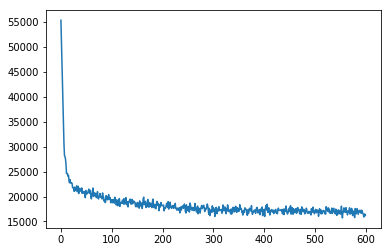

In [7]:
plt.plot(loss_record)

(784,)
torch.Size([784])


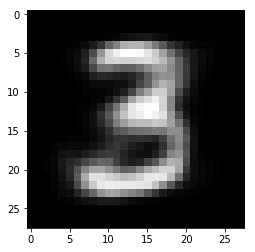

In [8]:
print(model(images)[0].data[0].numpy().shape)
image1 = images[8]
print(image1.shape)
plt.imshow(model(images)[0].data[8].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

# Testing

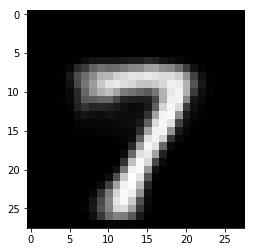

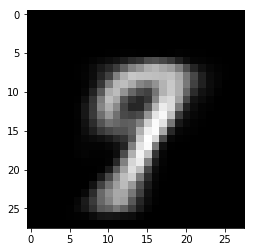

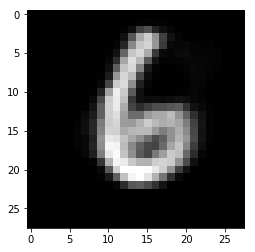

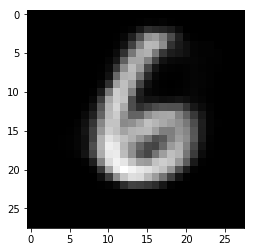

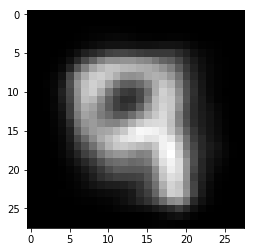

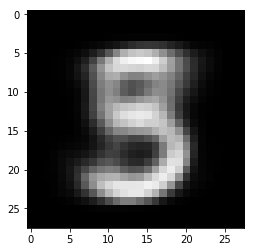

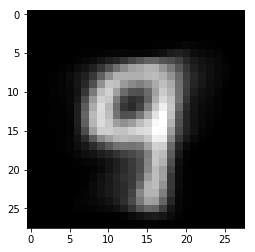

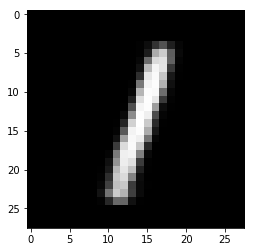

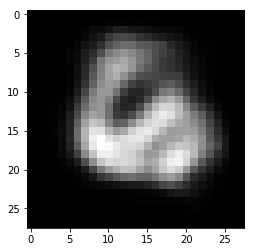

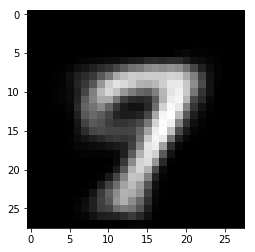

In [9]:
test_loss = 0
print_per = 10
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.reshape(-1, 28*28)
        recon_batch, mu, logvar = model(images)
        test_loss += loss_function(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(28, 28), cmap='gray')
            plt.show(block=True)

In [10]:
image2 = images[1]
print(image2.shape)

torch.Size([784])


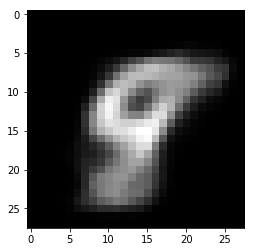

In [11]:
plt.imshow(model(images)[0].data[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

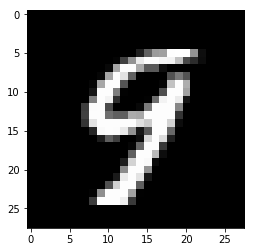

In [12]:
plt.imshow(images[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

# Experiments

Continued from the [previous notebook](https://github.com/ac-alpha/VAEs-using-Pytorch/blob/master/VAE.ipynb). Please see them first. 

In [13]:
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)

### 4. We will sample random z values from the linear space in increasing order. We will then decode these z values and map them to some digits obtained by the decoder.

In [14]:
n = 15
z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

In [15]:
print(z1, z2)

[-2.32634787e+00 -1.40507156e+00 -1.03643339e+00 -7.72193214e-01
 -5.53384720e-01 -3.58458793e-01 -1.76374165e-01 -1.39145821e-16
  1.76374165e-01  3.58458793e-01  5.53384720e-01  7.72193214e-01
  1.03643339e+00  1.40507156e+00  2.32634787e+00] [-2.32634787e+00 -1.40507156e+00 -1.03643339e+00 -7.72193214e-01
 -5.53384720e-01 -3.58458793e-01 -1.76374165e-01 -1.39145821e-16
  1.76374165e-01  3.58458793e-01  5.53384720e-01  7.72193214e-01
  1.03643339e+00  1.40507156e+00  2.32634787e+00]


In [16]:
with torch.no_grad():
    recon_images1 = []
    for xi in z1 :
        for yi in z2 : 
            z_val = torch.zeros_like(mu1)
            z_val[0] = xi
            z_val[1] = yi
            recon_image = model.decode(z_val)
            recon_images1.append(recon_image)

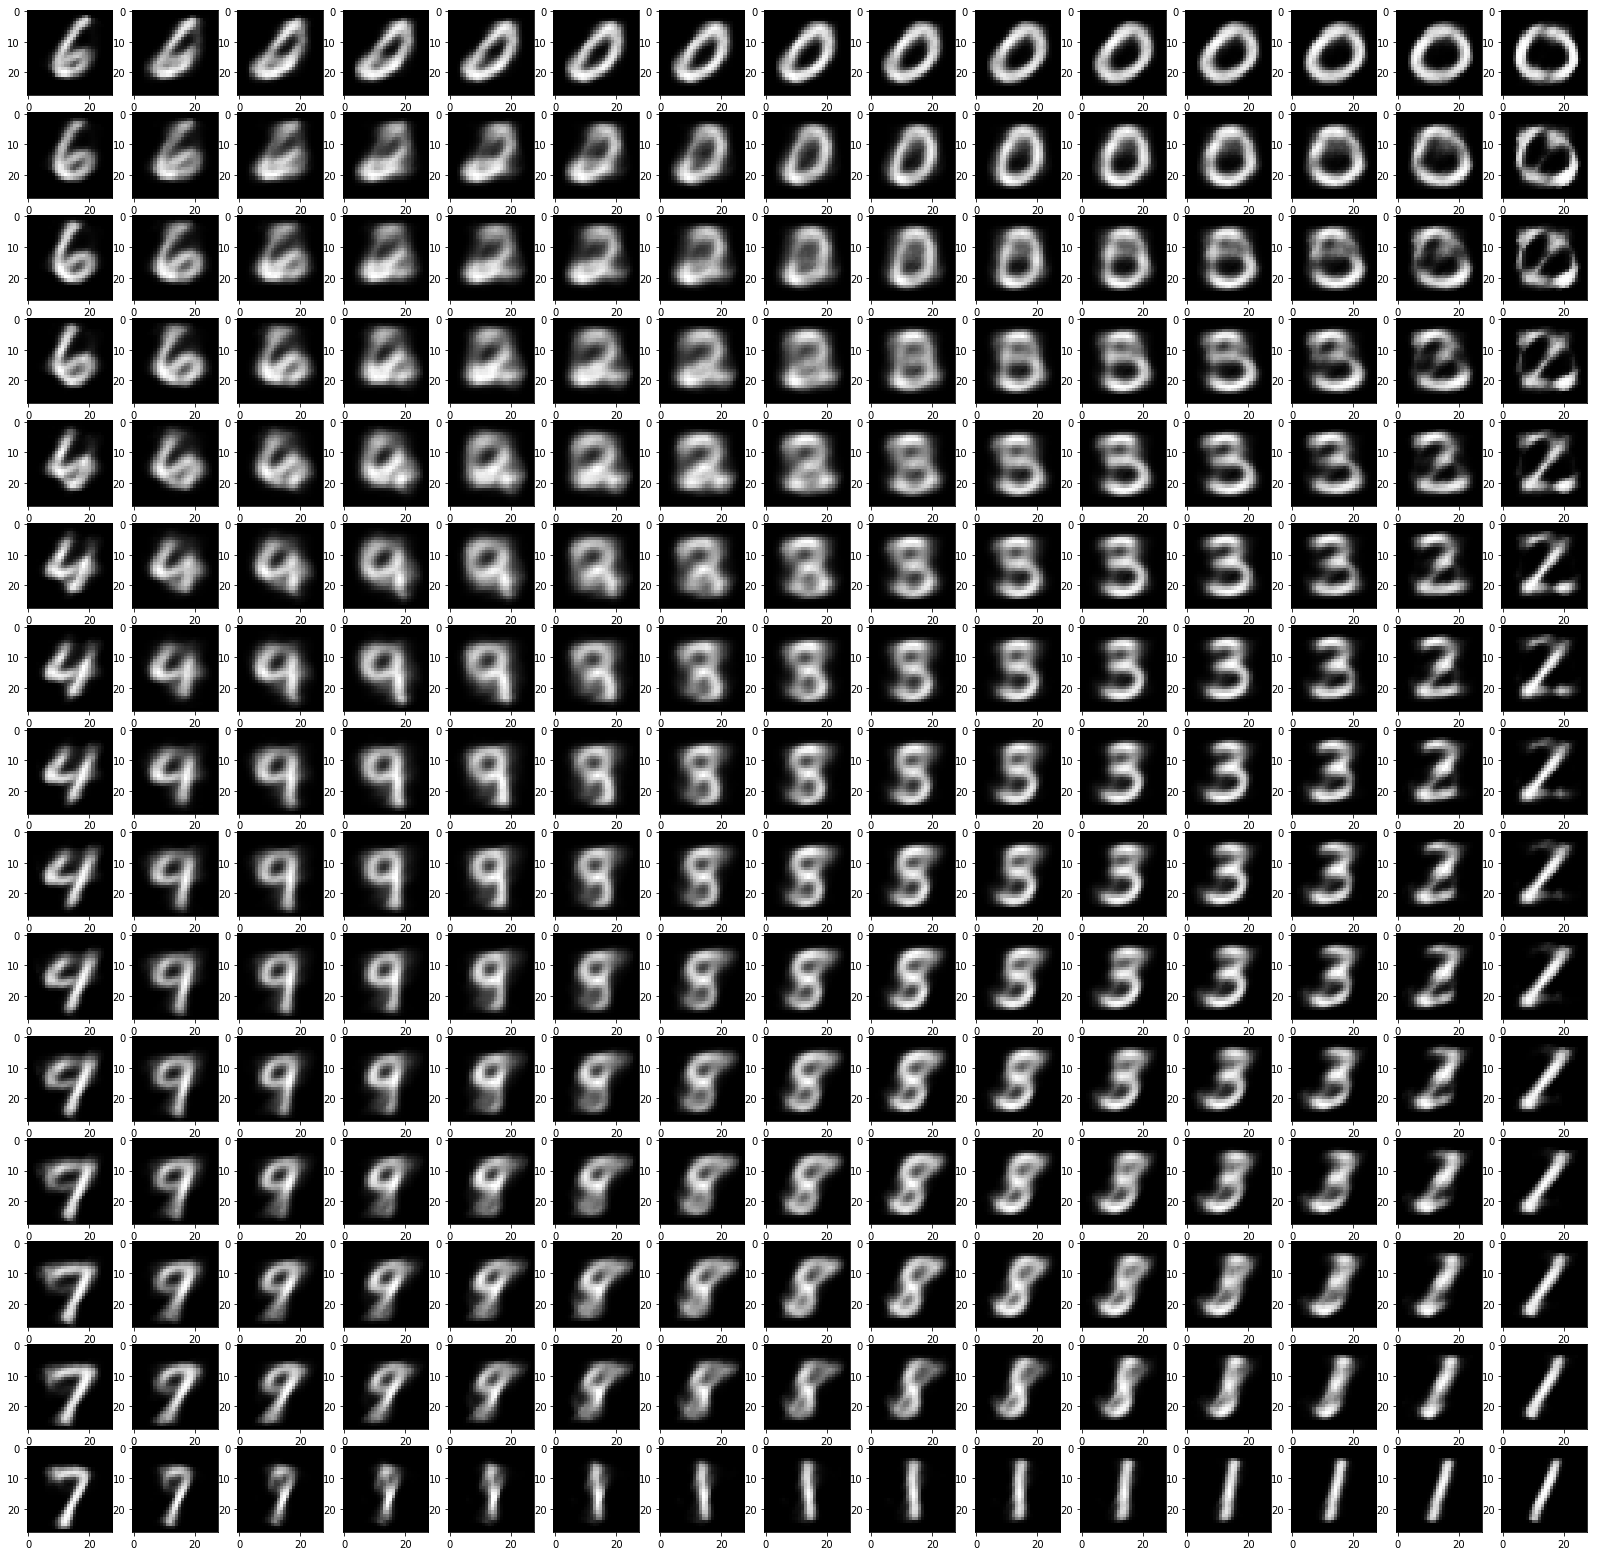

In [17]:
fig=plt.figure(figsize=(28, 28))
columns = 15
rows = 15
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

### 5. Creating a scatter plot for visualizing the space occupied by the z values corresponding to digits

Here we can see that all the blobs corresponding to some specific digit are close to one another so we can easily transition from one digit from other without having much noise.

In [18]:
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=2000, shuffle=False)

In [19]:
x_set, y_set = next(iter(test_loader))

In [20]:
x_set = x_set.reshape(-1, 28*28)

In [21]:
z_set = model.encode(x_set)[0].detach().numpy()

In [22]:
print(z_set.shape)

(2000, 2)


In [23]:
print(y_set.shape)
color = y_set

torch.Size([2000])


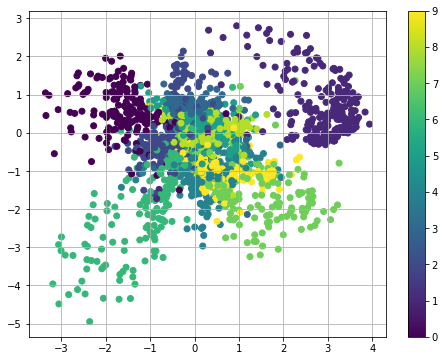

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(z_set[:, 0], z_set[:, 1], c=color, cmap = "viridis")
plt.colorbar()
plt.grid()